# 0. Import libraries & Load Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from data.data_loader import DataLoader
from utils.preprocessing import TimeSeriesPreprocessor
from models.lstm_model import LSTMModelWrapper  # Import the LSTM model
from models.xgboost_model import XGBoostModel
from models.catboost_model import CatBoostModel
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
from utils.visualize import plot_predictions

/home/hub-hamza/Downloads/KocDigitalCase/KocDigitalCase/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Initialize components
data_loader = DataLoader('../data/multistep_regression.csv')
df = data_loader.load_data()
df

,Year,Month,Value
date,,,
1999-01-01,1999,1,40.575599
1999-02-01,1999,2,65.182165
1999-03-01,1999,3,63.089448
1999-04-01,1999,4,81.853452
1999-05-01,1999,5,48.081737
...,...,...,...
2022-01-01,2022,1,38.527122
2022-02-01,2022,2,55.861375
2022-03-01,2022,3,80.490987


# 1.Exploratory Data Analysis

In [3]:
df.describe()

,Year,Month,Value
count,281.000000,281.000000,281.000000
mean,2010.213523,6.437722,33.195956
std,6.774740,3.463669,25.893953
min,1999.000000,1.000000,3.474676
25%,2004.000000,3.000000,15.062259
50%,2010.000000,6.000000,23.753365
75%,2016.000000,9.000000,41.247543
max,2022.000000,12.000000,139.154873


<Axes: xlabel='Year'>

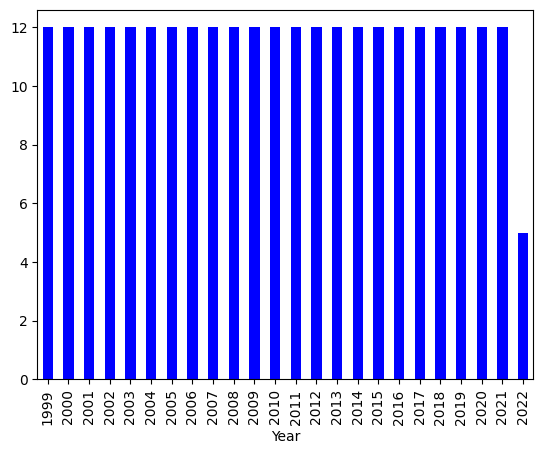

In [4]:
df["Year"].value_counts().sort_index().plot(kind='bar', color='blue')

- There seems to be no missing data.
- The data frequency is monthly.

# 2. Use of Traditional Methods (Xgboost, Catboost)

## 2.1 Feature Engineering & Preprocessing

In [5]:
preprocessor = TimeSeriesPreprocessor()

df = preprocessor.create_features(df)

The following features are extracted for feature engineering:

- **Prev_Year_Mean**: Average value of the target variable from the previous year (avoiding future leakage).  
- **Lag1_Inflow_6**: Value of the target variable from 6 months ago.  
- **Lag1_Inflow_12**: Value of the target variable from 12 months ago.  
- **Short_vs_Long_Term**: Difference between the short-term (3-month) and long-term (12-month) moving averages, using a 5-month lag.  
- **Month_Sin & Month_Cos**: Sine and cosine transformations of the month to capture seasonality cyclically.  
- **Year_Sin & Year_Cos**: Sine and cosine transformations of the year to capture long-term trends cyclically.  

In [6]:
# train = data[data.index.year < split_year]
# test = data[(data.index.year >= split_year) & (data.index.month <= 5)]

train, test = data_loader.split_data(df)

The train and test sets are splitted as follows:
- Train data: The data before 2020.
- Test data: This first 5 months after 2020 (including).

In [7]:
train

,Year,Month,Value,Prev_Year_Mean,Lag1_Inflow_6,Lag1_Inflow_12,Short_vs_Long_Term,Month_Sin,Month_Cos,Year_Sin,Year_Cos
date,,,,,,,,,,,
2000-05-01,2000,5,71.659560,33.390943,14.388636,48.081737,-18.012054,5.000000e-01,-8.660254e-01,-0.866025,-5.000000e-01
2000-06-01,2000,6,26.482899,33.390943,16.142621,24.487741,-12.134585,1.224647e-16,-1.000000e+00,-0.866025,-5.000000e-01
2000-07-01,2000,7,11.270656,33.390943,30.791891,12.416174,-3.275926,-5.000000e-01,-8.660254e-01,-0.866025,-5.000000e-01
2000-08-01,2000,8,14.326710,33.390943,32.892093,7.119303,11.703734,-8.660254e-01,-5.000000e-01,-0.866025,-5.000000e-01
2000-09-01,2000,9,10.812216,33.390943,60.412320,11.749033,43.049610,-1.000000e+00,-1.836970e-16,-0.866025,-5.000000e-01
...,...,...,...,...,...,...,...,...,...,...,...
2019-08-01,2019,8,21.042764,27.515803,58.039700,31.452783,29.139225,-8.660254e-01,-5.000000e-01,1.000000,4.653844e-14
2019-09-01,2019,9,20.663660,27.515803,60.509732,18.546146,32.462404,-1.000000e+00,-1.836970e-16,1.000000,4.653844e-14
2019-10-01,2019,10,24.216716,27.515803,106.099785,22.367401,32.990396,-8.660254e-01,5.000000e-01,1.000000,4.653844e-14


In [8]:
test

,Year,Month,Value,Prev_Year_Mean,Lag1_Inflow_6,Lag1_Inflow_12,Short_vs_Long_Term,Month_Sin,Month_Cos,Year_Sin,Year_Cos
date,,,,,,,,,,,
2020-01-01,2020,1,40.818475,45.909451,19.474606,77.886218,-20.543508,0.500000,8.660254e-01,8.660254e-01,-0.500000
2020-02-01,2020,2,51.462599,45.909451,21.042764,58.039700,-26.162098,0.866025,5.000000e-01,8.660254e-01,-0.500000
2020-03-01,2020,3,81.438948,45.909451,20.663660,60.509732,-24.735505,1.000000,6.123234e-17,8.660254e-01,-0.500000
2020-04-01,2020,4,86.329096,45.909451,24.216716,106.099785,-26.202104,0.866025,-5.000000e-01,8.660254e-01,-0.500000
2020-05-01,2020,5,51.819910,45.909451,18.317547,71.782898,-19.768118,0.500000,-8.660254e-01,8.660254e-01,-0.500000
2021-01-01,2021,1,33.547298,37.980623,16.739063,40.818475,-18.944794,0.500000,8.660254e-01,5.000000e-01,-0.866025
2021-02-01,2021,2,50.566502,37.980623,20.845344,51.462599,-18.954236,0.866025,5.000000e-01,5.000000e-01,-0.866025
2021-03-01,2021,3,57.122634,37.980623,24.570318,81.438948,-17.620925,1.000000,6.123234e-17,5.000000e-01,-0.866025
2021-04-01,2021,4,55.491812,37.980623,19.579757,86.329096,-16.822087,0.866025,-5.000000e-01,5.000000e-01,-0.866025


In [9]:
# Prepare features
X_train, X_test, y_train, y_test = preprocessor.prepare_data(train, test)

/home/hub-hamza/Downloads/KocDigitalCase/KocDigitalCase/regression/src/utils/preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['Year', 'Month'], axis=1, inplace=True)
/home/hub-hamza/Downloads/KocDigitalCase/KocDigitalCase/regression/src/utils/preprocessing.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['Year', 'Month'], axis=1, inplace=True)


# 2.2 Training & Results

In [10]:
# Initialize and train models
models = {
    'XGBoost': XGBoostModel(n_trials=50),
    'CatBoost': CatBoostModel(n_trials=50)
}

In [11]:
predictions = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.train(X_train, y_train, X_test, y_test)
    predictions[name] = model.predict(X_test)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, predictions[name])
    rmse = np.sqrt(mean_squared_error(y_test, predictions[name]))
    mape = mean_absolute_percentage_error(y_test, predictions[name])
    print(f"{name} MAE: {mae:.2f}")
    print(f"{name} RMSE: {rmse:.2f}")
    print(f"{name} MAPE(%): {mape*100:.2f}%")  # Convert to percentage
    
    # Print feature importance
    print(f"\n{name} Feature Importance:")
    importance = model.get_feature_importance()
    for feature, imp in sorted(importance.items(), key=lambda x: x[1], reverse=True):
        print(f"{feature}: {imp:.4f}")


Training XGBoost...
Best hyperparameters: {'n_estimators': 527, 'learning_rate': 0.005782862870183744, 'max_depth': 4, 'min_child_weight': 8.878112803391044, 'gamma': 0.29964151332638633, 'subsample': 0.9980785226181565, 'colsample_bytree': 0.6278999178288358, 'reg_alpha': 3.468521711600089, 'reg_lambda': 3.6388598632143774}
XGBoost MAE: 8.78
XGBoost RMSE: 11.87
XGBoost MAPE(%): 17.85%

XGBoost Feature Importance:
Month_Sin: 0.4240
Lag1_Inflow_6: 0.1318
Lag1_Inflow_12: 0.1206
Month_Cos: 0.1138
Short_vs_Long_Term: 0.0553
Prev_Year_Mean: 0.0540
Year_Cos: 0.0511
Year_Sin: 0.0494

Training CatBoost...
Best hyperparameters: {'iterations': 898, 'learning_rate': 0.005003718946787005, 'depth': 3, 'l2_leaf_reg': 5.924700160428131, 'random_strength': 0.00021253232960458611, 'bagging_temperature': 0.8462824773938179, 'border_count': 188}
CatBoost MAE: 7.72
CatBoost RMSE: 10.11
CatBoost MAPE(%): 17.46%

CatBoost Feature Importance:
Month_Sin: 50.6376
Month_Cos: 17.5200
Lag1_Inflow_6: 9.0478
Short

The hyperparameter optimization is conducted with the Optuna framework.  
Here are the best parameters for XGBoost:

- **n_estimators**: 527  
- **learning_rate**: 0.005782862870183744  
- **max_depth**: 4  
- **min_child_weight**: 8.878112803391044  
- **gamma**: 0.29964151332638633  
- **subsample**: 0.9980785226181565  
- **colsample_bytree**: 0.6278999178288358  
- **reg_alpha**: 3.468521711600089  
- **reg_lambda**: 3.6388598632143774  


Here are the best parameters for Catboost:
- **iterations**: 898  
- **learning_rate**: 0.005003718946787005  
- **depth**: 3  
- **l2_leaf_reg**: 5.924700160428131  
- **random_strength**: 0.00021253232960458611  
- **bagging_temperature**: 0.8462824773938179  
- **border_count**: 188  


In terms of feature importances, both models give attention to the cyclic month features. The other lagged features was also helpful reducing the errors.

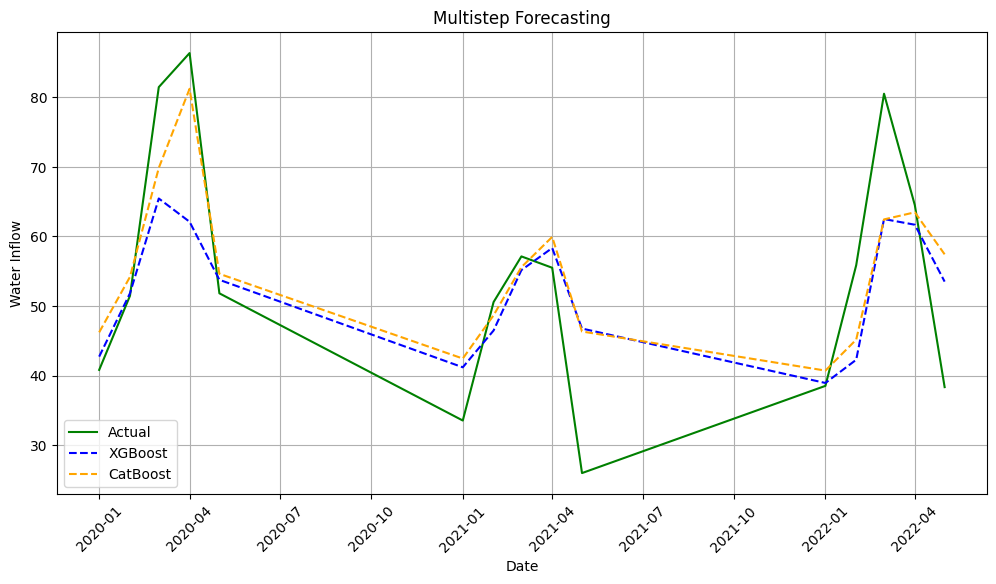

In [12]:
plot_predictions(y_test, predictions, title='Multistep Forecasting')

- As you see, both models perform relatively good. Catboost performs slightly better in MAE, RMSE, and MAPE metrics.

# 3. Use of Deep Learning Method (LSTM)

## 3.1 Preprocessing

In [13]:
data = data_loader.load_data()
data = preprocessor.create_features(data)
train, test = data_loader.split_data(data)

- Apply the same preprocessing in the previous section.

## 3.2 Training

In [48]:
# Initialize and train models
models = {
    'LSTM': LSTMModelWrapper(input_size=11, hidden_size=100, num_layers=1, output_size=1, dropout=0.1)
}

- Optuna can be applied to LSTM as well but after experimenting, I manually fine tuned the hyperparameters.

In [49]:
target_column = 'Value' 

predictions = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    # Train the model with Optuna hyperparameter optimization
    model.train(
        data, 
        target_column=target_column, 
        seq_length=1, 
        num_epochs=50, 
        batch_size=32, 
        learning_rate=0.01, 
        use_optuna=False 
    )
    
    # Make predictions
    predictions[name] = model.predict(test, target_column=target_column, num_predictions=len(test))
    
    # Calculate metrics
    y_test = test[target_column].values[-len(predictions[name]):]  # Align test data with predictions
    mae = mean_absolute_error(y_test, predictions[name])
    rmse = np.sqrt(mean_squared_error(y_test, predictions[name]))
    mape = mean_absolute_percentage_error(y_test, predictions[name])
    print(f"{name} MAE: {mae:.2f}")
    print(f"{name} RMSE: {rmse:.2f}")
    print(f"{name} MAPE(%): {mape*100:.2f}%")  # Convert to percentage



Training LSTM...


/home/hub-hamza/Downloads/KocDigitalCase/KocDigitalCase/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/50, Loss: 0.0439
Epoch 2/50, Loss: 0.0256
Epoch 3/50, Loss: 0.0239
Epoch 4/50, Loss: 0.0230
Epoch 5/50, Loss: 0.0214
Epoch 6/50, Loss: 0.0208
Epoch 7/50, Loss: 0.0196
Epoch 8/50, Loss: 0.0172
Epoch 9/50, Loss: 0.0147
Epoch 10/50, Loss: 0.0142
Epoch 11/50, Loss: 0.0146
Epoch 12/50, Loss: 0.0139
Epoch 13/50, Loss: 0.0115
Epoch 14/50, Loss: 0.0106
Epoch 15/50, Loss: 0.0092
Epoch 16/50, Loss: 0.0086
Epoch 17/50, Loss: 0.0086
Epoch 18/50, Loss: 0.0082
Epoch 19/50, Loss: 0.0081
Epoch 20/50, Loss: 0.0079
Epoch 21/50, Loss: 0.0074
Epoch 22/50, Loss: 0.0075
Epoch 23/50, Loss: 0.0072
Epoch 24/50, Loss: 0.0070
Epoch 25/50, Loss: 0.0068
Epoch 26/50, Loss: 0.0068
Epoch 27/50, Loss: 0.0066
Epoch 28/50, Loss: 0.0066
Epoch 29/50, Loss: 0.0077
Epoch 30/50, Loss: 0.0080
Epoch 31/50, Loss: 0.0128
Epoch 32/50, Loss: 0.0143
Epoch 33/50, Loss: 0.0116
Epoch 34/50, Loss: 0.0080
Epoch 35/50, Loss: 0.0114
Epoch 36/50, Loss: 0.0116
Epoch 37/50, Loss: 0.0098
Epoch 38/50, Loss: 0.0078
Epoch 39/50, Loss: 0.

/home/hub-hamza/Downloads/KocDigitalCase/KocDigitalCase/regression/src/models/lstm_model.py:258: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_column + '_scaled'] = data_scaled


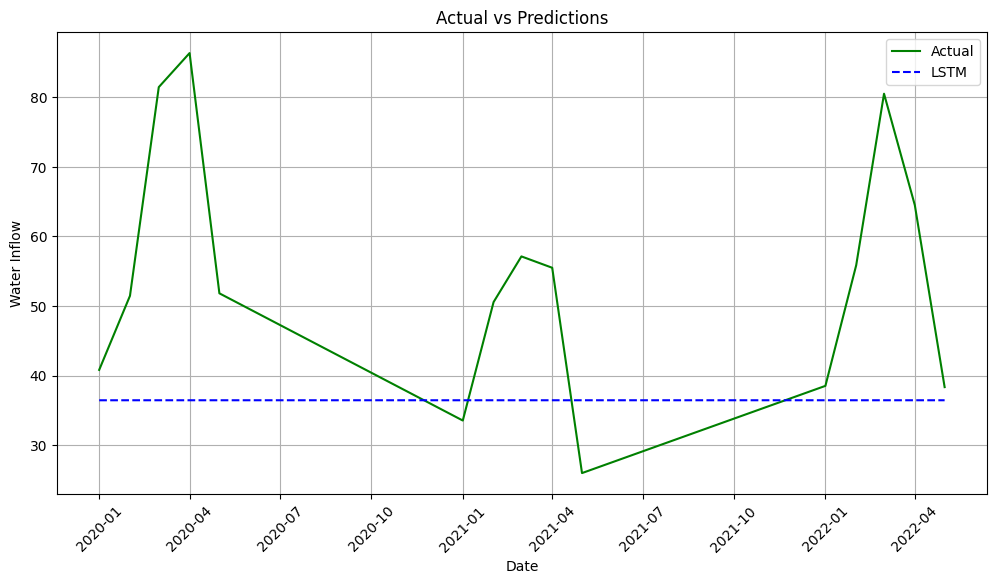

In [50]:
plot_predictions(test[target_column].iloc[-len(predictions['LSTM']):], predictions)

The LSTM model encounter with the lazy learning problem. The cause of this is probably vanishing gradient problem. Things I could do:
- Layer Normalization
- Increase model complexity
- Change activation function